# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Benjamin Chooyin, Estelle McCool, Brad Wang, Alyssa Heggison (Group 26) 

## General Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

In [2]:
# Load data
data = pd.read_csv("the_office.csv")
data = pd.DataFrame(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB
None
Ken Kwapis
Ken Kwapis
Ken Whittingham
Bryan Gordon
Greg Daniels
Amy Heckerling
Greg Daniels
Ken Kwapis
Paul Feig
Ken Kwapis
Paul Feig
Ken Kwapis
Greg Daneils
Paul Feig
Paul Feig
Char

/var/folders/_6/_cc_7cw56hs871xb2xw9c38c0000gn/T/ipykernel_23798/2063966743.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.director[i] = [data.director[i]]
/var/folders/_6/_cc_7cw56hs871xb2xw9c38c0000gn/T/ipykernel_23798/2063966743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.main_chars[i] = data.main_chars[i].split(';')


After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

We do an exploratory data analysis to get a sense of the variables

First we take an elementary look at some random rows of it as well as check the data types of the columns and the existence of missing values in data.

In [10]:
data.sample(10)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
73,5,10,The Surplus,Paul Feig,Gene Stupnitsky;Lee Eisenberg,8.7,2070,2008-12-04,323,44,2720,16,Andy;Angela;Creed;Dwight;Jim;Kelly;Kevin;Mered...
120,7,6,Costume Contest,Dean Holland,Justin Spitzer,8.2,1663,2010-10-28,284,47,3206,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...
63,4,17,Job Fair,Tucker Gates,Lee Eisenberg;Gene Stupnitsky,7.9,1977,2008-05-08,188,55,2256,20,Andy;Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevi...
162,8,24,Free Family Portrait Studio,B.J. Novak,B.J. Novak,7.8,1464,2012-05-10,295,35,2667,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...
35,3,8,The Merger,Ken Whittingham,Brent Forrester,8.7,2376,2006-11-16,474,52,3984,21,Andy;Angela;Creed;Dwight;Jim;Kelly;Kevin;Mered...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
90,5,28,Company Picnic,Ken Kwapis,Jennifer Celotta;Paul Lieberstein,8.9,2232,2009-05-14,273,72,2512,25,Andy;Angela;Dwight;Erin;Jim;Kevin;Meredith;Mic...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
164,9,2,Roy's Wedding,Matt Sohn,Allison Silverman,7.2,1477,2012-09-27,296,95,2908,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...
117,7,3,Andy's Play,John Scott,Charlie Grandy,8.2,1802,2010-10-07,229,33,2334,17,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


A few observations could be made.

1. The data contains numerical values and strings, where the latter needs to be encoded to be utilised by the model.
2. The columns $\texttt{season}$, $\texttt{episode}$ and $\texttt{total\_votes}$ are not controllable in terms of film producing, and so should not be considered as inputs of the final model. However, we could still test their correlations with the rating. 
3. The column $\texttt{air\_date}$ needs to be transformed (e.g. into the number of days from the eariliest airdate) to be used as a numerical variable. 
4. The strings of the columns $\texttt{writers}$ and $\texttt{main\_chars}$ are writer/character names separated by $\textbf{;}$, and we would split them and then encode the apprearance of each individual writer/character. 
5. The name of a episode might have effects on the number of people who decide to watch it, and thereby the number of votes it gets. However, considering we have a relatively small dataset (186 observations), the analysis of the effects of episode names (Further research: natural language processing and semantic analysis)
6. There are no missing values in the data.

We further take a look at the scaling and distributing features of the data.

In [12]:
data.describe()

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


'Many of these pairplots contain little information but there are some interesting trends. Season 8 was unpopular.\nThe ratings are normally distributed, The number of lines and number of words are strongly correlated so we may not need both \nvariables. Total votes and imbd rating look like they could have some qaudratic correlation \n'

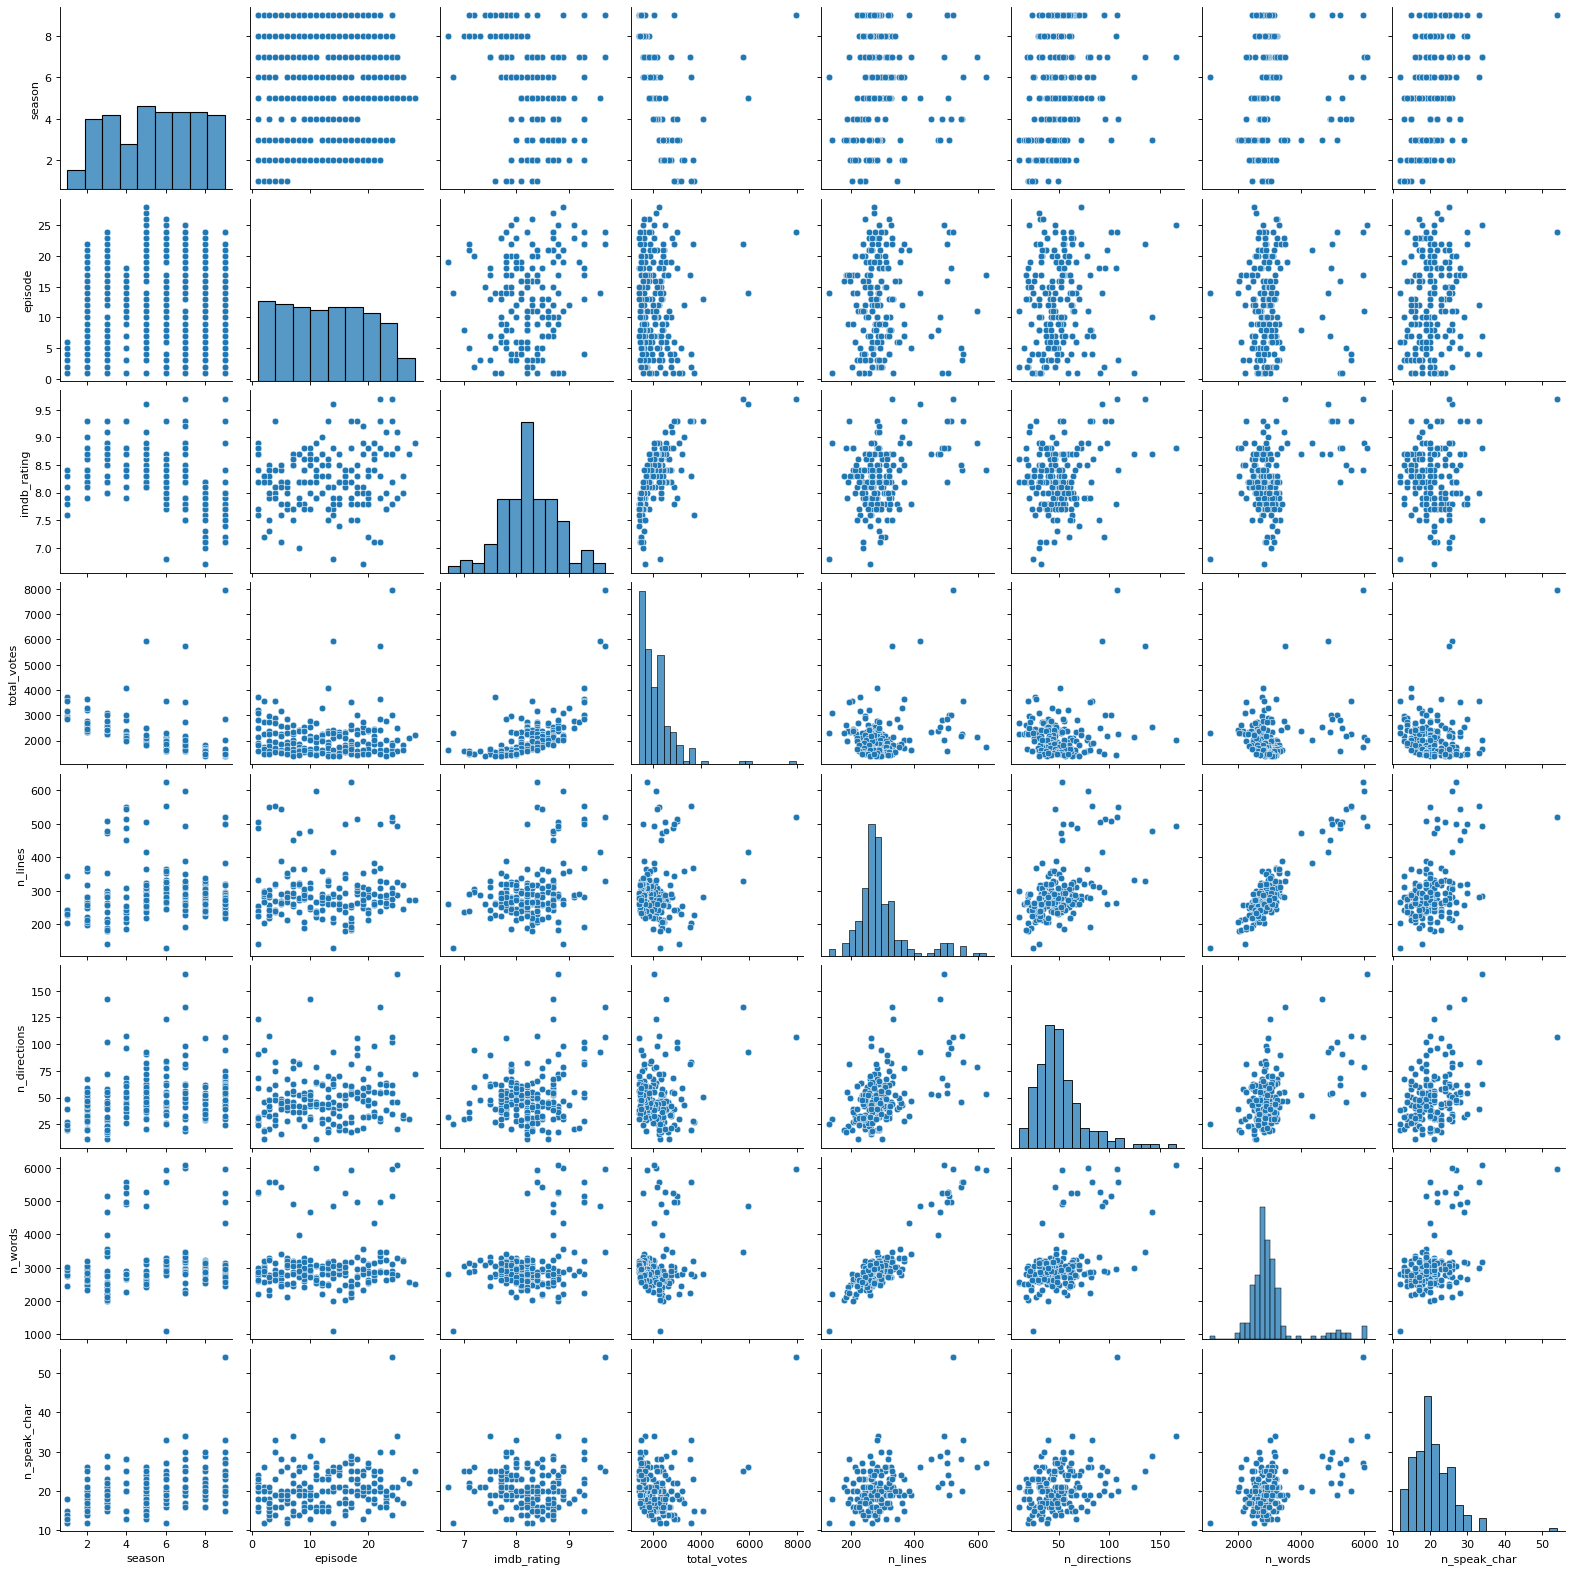

In [18]:
# The data contains 186 episodes with a mean ammount of votes 2130 per episode and a mean rating of 8.25. 
sns.pairplot(data)

The described statictics show that numerical variables are of quite different scales, which implies normalisation might need to be performed. Many of these pairplots contain little information but there are some interesting trends. 

1. Season 8 was particularly unpopular.
2. The ratings are normally distributed.
3. The number of lines and number of words are strongly correlated so we may not need both variables. 
4. There seems to be some quadratic correlation between the total votes and the imbd rating.

In [4]:
data.corr()

/tmp/ipykernel_9271/2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
episode,1.000000,0.179985,0.020161,0.034908,0.125925,0.055552,0.184197
imdb_rating,0.179985,1.000000,0.653973,0.348994,0.226286,0.337212,0.091992
total_votes,0.020161,0.653973,1.000000,0.205062,0.182462,0.265325,0.178324
n_lines,0.034908,0.348994,0.205062,1.000000,0.487551,0.915959,0.416188
n_directions,0.125925,0.226286,0.182462,0.487551,1.000000,0.511985,0.350052
n_words,0.055552,0.337212,0.265325,0.915959,0.511985,1.000000,0.480967
n_speak_char,0.184197,0.091992,0.178324,0.416188,0.350052,0.480967,1.000000


In [5]:
#One hot encoding  all of the categorical columns
#Import function for multi variable one hot encoder 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#Directors
encoded_directors = pd.DataFrame(mlb.fit_transform(data['director']), columns= mlb.classes_)

#Writer
encoded_writers = pd.DataFrame(mlb.fit_transform(data['writer']), columns= mlb.classes_)

#Seasons as although they are an integer we dont want them to behave like an integer
encoded_seasons = pd.DataFrame(mlb.fit_transform(data['season']), columns= mlb.classes_)

#One hot encoding the main characters
encoded_characters = pd.DataFrame(mlb.fit_transform(data["main_chars"]), columns= mlb.classes_)

     1  2  3  4  5  6  7  8  9
0    1  0  0  0  0  0  0  0  0
1    1  0  0  0  0  0  0  0  0
2    1  0  0  0  0  0  0  0  0
3    1  0  0  0  0  0  0  0  0
4    1  0  0  0  0  0  0  0  0
..  .. .. .. .. .. .. .. .. ..
181  0  0  0  0  0  0  0  0  1
182  0  0  0  0  0  0  0  0  1
183  0  0  0  0  0  0  0  0  1
184  0  0  0  0  0  0  0  0  1
185  0  0  0  0  0  0  0  0  1

[186 rows x 9 columns]


'Attempt to one hot encode main characters\n#for i in range(0,len(data.main_chars)):\n#   data.main_chars[i] = data.main_chars[i].split(\';\')\nmylist = []\nfor i in range(0,len(data.main_chars)):\n    for j in range(0,len(data.main_chars[i])):\n        mylist.append(data.main_chars[i][j])\nmylist= [set(mylist)]\nprint(mylist)\n\n\n\n#encoded = pd.Data_Frame(mlb.fit_transform([spaced_data["main_chars"]]), columns= mlb.classes_)\n#result = pd.concat([data[\'main_chars\'], encoded], axis=1)\n#result\n\n'

In [9]:
#Data Formatting
data_numeric = data.copy()

#split character column by columns instead of semicolons
for i in range(0,len(data_numeric.main_chars)):
   data_numeric.main_chars[i] = data_numeric.main_chars[i].split(';')
#same for writer column
for i in range(0,len(data_numeric.writer)):
   data_numeric.writer[i] = data_numeric.writer[i].split(';')
#Director
for i in range(0,len(data_numeric.director)):
   data_numeric.director[i] = data_numeric.director[i].split(';')

#turn season data into a string for future use
data_numeric.season = data_numeric.season.astype(str)

#Joining the One hot encoded columns with the original data frame
data_numeric = data_numeric.join([encoded_seasons,encoded_characters])
data_numeric = data_numeric.drop(['director','season', 'main_chars','episode_name','air_date','writer'], axis=1)

data_numeric = data_numeric.join(encoded_writers, lsuffix = ' Writer')
data_numeric = data_numeric.join(encoded_directors, lsuffix = ' Director')

#print(data_numeric.head())
#pd.set_option('display.max_columns', None)

,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,Alex Hardcastle,Amy Heckerling,Asaad Kelada,B.J. Novak,Brent Forrester,Brian Baumgartner,Bryan Cranston,Bryan Gordon,Charles McDougal,Charles McDougall,Charlie Grandy,Claire Scanlon,Claire Scanlong,Craig Zisk,Daniel Chun,Danny Leiner,David Rogers,Dean Holland,Dennie Gordon,Ed Helms,Eric Appel,Gene Stupnitsky;Lee Eisenberg,Greg Daneils,Greg Daniels,Harold Ramis,J.J. Abrams,Jason Reitman,Jeffrey Blitz,Jennifer Celotta,Jesse Peretz,John Krasinski,John Scott,Jon Favreau,Joss Whedon,Julian Farino,Kelly Cantley-Kashima,Ken Kwapis,Ken Whittingham,Ken Wittingham,Lee Eisenberg;Gene Stupnitsky,Lee Kirk,Marc Webb,Matt Sohn,Michael Spiller,Miguel Arteta,Mindy Kaling,Paul Feig,Paul Lieberstein,Paul Lieerstein,Rainn Wilson,Randall Einhorn,Reginald Hudlin,Rodman Flender,Roger Nygard,Seth Gordon,Seth Gordon;Harold Ramis,Stephen Merchant,Steve Carell,Troy Miller,Tucker Gates,Victor Nelli Jr.,1,2,3,4,5,6,7,8,9
0,1,7.6,3706,229,27,2757,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2,8.3,3566,203,20,2808,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3,7.9,2983,244,21,2769,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,4,8.1,2886,243,24,2939,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,5,8.4,3179,230,49,2437,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


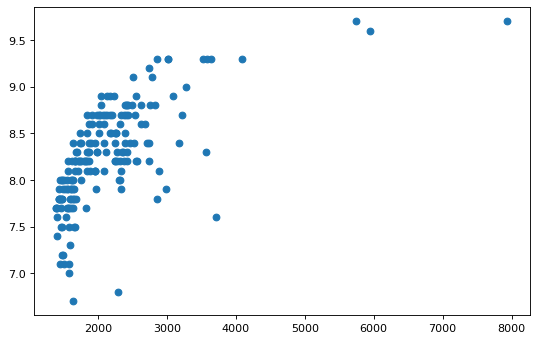

In [6]:
# Looking more closely at the total votes variable
# Correlation coeff of 0.65 with imdb_rating 

fig1, ax1 = plt.subplots()
ax1.scatter(data['total_votes'], data['imdb_rating'])

# There looks like a quadratic relationship
# We may not want to include total_votes as a predictor though, because it's not something 
# that the filming team can control. 

# But maybe we could argue for maximising total_votes as a response variable, rather than rating
# We will try this below 

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#I think we have a problem because the binary columns are being scaled.
# There are no zero or 1 values left in the directors columns  
#print(X_train)
# Actually all the values in X_train seem weird/ a lot of negatives - maybe we have made an error in the scaling? 

#Idea to fix this 
# Dropping all binary, text, date features frist

# Separating features from the rating we want to predict
X = data_numeric.drop('imdb_rating', axis = 1) 
y = data_numeric['imdb_rating']

# Selecting and scaling only the real variables, not the encoded categorical variables 
X_real_only = data_numeric[['episode', 'total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char']]
X_bin_only = data_numeric.drop(['imdb_rating', 'episode', 'total_votes', 'n_lines', 'n_directions', 'n_words', 'n_speak_char' ], axis = 1)
X_bin_array = X_bin_only.to_numpy()

#Scaling the real variables before joining the encoded columns back on
X_real_scaled = scaler.fit_transform(X_real_only)
X_scaled = np.concatenate((X_real_scaled, X_bin_array), axis = 1)

# Splitting into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)
print(X_scaled[0,:])


[-1.59108889  1.99890839 -0.82415781 -0.96956057 -0.37197745 -1.12106433
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [11]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [12]:

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [10]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 77 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   episode                        186 non-null    int64  
 1   imdb_rating                    186 non-null    float64
 2   total_votes                    186 non-null    int64  
 3   n_lines                        186 non-null    int64  
 4   n_directions                   186 non-null    int64  
 5   n_words                        186 non-null    int64  
 6   n_speak_char                   186 non-null    int64  
 7   Alex Hardcastle                186 non-null    int64  
 8   Amy Heckerling                 186 non-null    int64  
 9   Asaad Kelada                   186 non-null    int64  
 10  B.J. Novak                     186 non-null    int64  
 11  Brent Forrester                186 non-null    int64  
 12  Brian Baumgartner              186 non-null    int

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

'''X = np.c_[X_train.bmi, 
          X_train.age,
          X_train.children,
          X_train.sex_female,
          X_train.smoker_yes
          ]'''
          
X_arr = np.array(X_train)
y_arr = np.array(y_train)

linreg = LinearRegression()
lm = linreg.fit(X_arr, y_train)
beta = get_coefs(lm)
print(beta)

[ 2.17951326e+10  9.81042060e-03  2.84526355e-01  1.43064986e-01
 -1.97521135e-02  1.09751712e-01 -1.08332402e-01  8.90946928e+08
  8.90946928e+08 -1.36153282e+10  8.90946928e+08  8.90946928e+08
  8.90946928e+08  8.90946928e+08  8.90946928e+08  8.90946928e+08
  8.90946928e+08  3.71786677e+09  8.90946927e+08  8.90946927e+08
  8.90946927e+08  2.83912920e+09 -8.72190227e+08  8.90946928e+08
  8.90946928e+08  8.90946928e+08  8.90946928e+08  8.90946928e+08
  8.90946928e+08 -1.56951004e+07  8.90946928e+08  8.90946928e+08
  8.90946928e+08  8.90946928e+08  8.90946928e+08  8.90946928e+08
  8.90946928e+08  8.90946928e+08  8.90946928e+08  8.90946928e+08
  8.90946929e+08  8.90946929e+08  8.90946928e+08  8.90946928e+08
  8.90946928e+08  1.12603141e+00  3.03840563e-02 -1.47476792e-02
  8.90946928e+08  8.90946928e+08  1.01152925e-06  8.90946928e+08
  8.90946929e+08  8.90946928e+08  8.90946928e+08  8.90946928e+08
  8.90946927e+08  8.90946928e+08  8.90946928e+08  8.90946928e+08
  9.14871882e-17 -5.55111

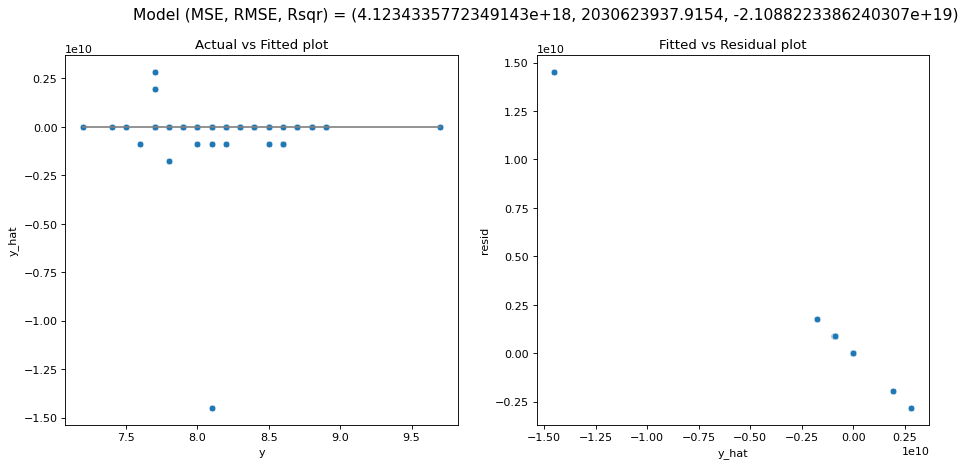

(4.1234335772349143e+18, 2030623937.9153676, -2.1088223386240307e+19)

In [31]:
#Realised we don't need to do this as they are already arrays 
X_test_arr = np.array(X_test)
y_test_arr = np.array(y_test)

model_fit(lm, X_test_arr, y_test_arr, plot = True)

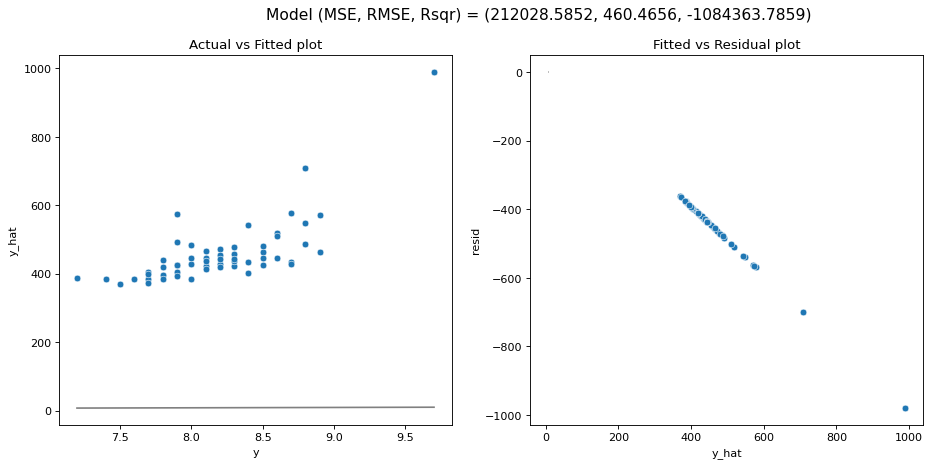

(212028.5851535034, 460.46561777564176, -1084363.7858598263)

In [30]:
# First attempt at Ridge Regression 
from sklearn.linear_model import Ridge

#Setting alpha value
a = 100

#Fitting the ridge regression model to the training set
ridge_scaled = make_pipeline(
    StandardScaler(),
    Ridge(alpha = a)
).fit(X_arr, y_arr)

#Testing the ridge regression model on the testing set
model_fit(ridge_scaled, X_test_arr, y_test_arr, plot = True)


{'ridge__alpha': 39.497487437185924}


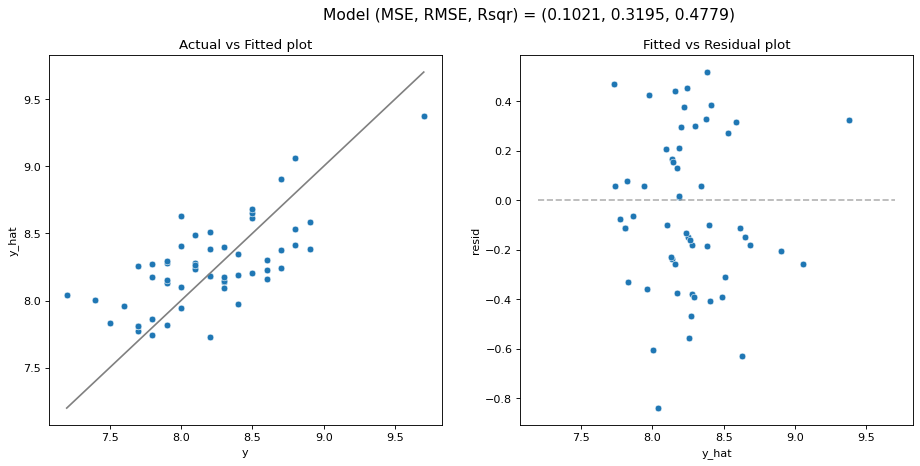

(0.10209096495932814, 0.31951676788445416, 0.4778824408218446)

In [24]:
#Parameter tuning using method from WS5

alphas = np.linspace(0, 60, num=200)

gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs.fit(X_arr, y_arr)
print(gs.best_params_)
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

#This gives a worse R^2 than above with a = 100, but I think a=38 is better because it's the one
#that was deemed the best when running 5-fold cross-valudation 

In [ ]:
#Removing the directors variables to see if this gives a better R^2



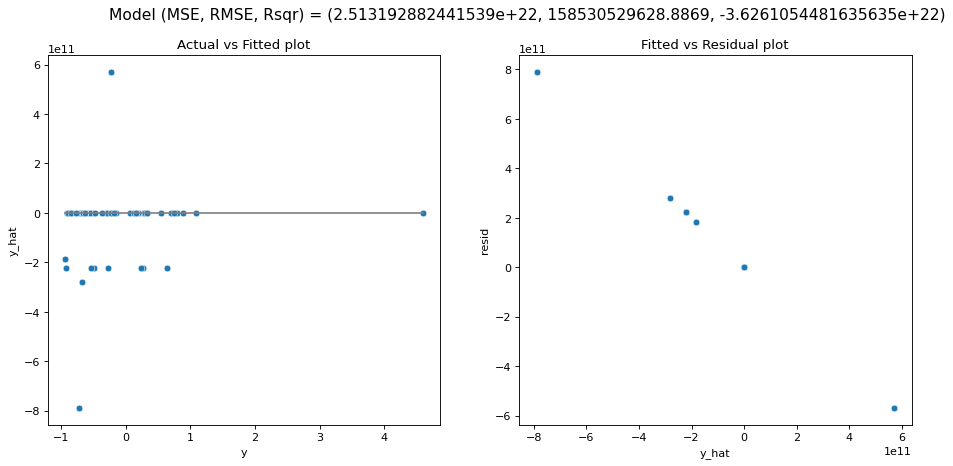

(2.513192882441539e+22, 158530529628.8869, -3.6261054481635635e+22)

In [39]:
#Trying out total votes as a dependent variable 
# This might not work out because rating has higher correlation with more variables

#Creating feature and response arrays  
tvX_scaled = np.delete(X_scaled, 1, 1) #object = 1, axis = 1
tv = X_scaled[:,1]

#Splitting into training and testing sets 
tvX_train, tvX_test, tvy_train, tvy_test = train_test_split(tvX_scaled, tv, test_size = 0.3, random_state = 42)

linreg = LinearRegression()
lmtv = linreg.fit(tvX_train, tvy_train)

model_fit(lmtv, tvX_test, tvy_test, plot = True)

#I think something is still wrong with the model but hopefully when we fix it above it'll carry through


## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from